# Business Understanding

For this analysis, our group will be working with the Belk Foundation data sets from 2014 to 2017.  These data sets encompass information across 4 continuous years of attributes pertaining to public education in North Carolina, USA. Among other reasons, the data were collected for evaluation of public school performance for the purpose of efficiently allocating funds to various educational initiatives. Analyses of such data are important because high-impact educational initiatives that are well-funded contribute to increased graduation rates, increased achievement at the post-secondary level, less crime, and greater economic engagement among young people.  For the purpose of this exercise, our focus is on describing and predicting school performance using various school characteristics, such as type of school (elementary, middle, high, or some combination of the three), social demographics, economic demographics, and location between 2014 and 2017.  The Belk Foundation's website says, "Our goal is to empower today’s workforce by creating pathways to and through postsecondary education for underrepresented students". For the sake of this analysis, we assume that better performing schools have better outcomes in postsecondary education. With North Carolina's rapidly-changing demographics,it is important to take into consideration schools' unique needs when allocating funds to strategic investment initiatives. Here, we explore where funding can be best applied based on educational achievement data.

In order to achieve this goal, we will explore through visual and mathematical modeling which features best predict the School Performance Grade (SPG), a continuous measure of a school's overall success based on test scores and growth measures. The analysis will come in the form of a regression model, and accuracy of the model will be determined by the root mean-squared error (RMSE).


# Data Meaning Type

# Data Quality

# Simple Statistics

# Visualize Attributes

# Explore Joint Attributes

# Explore Attributes and Class

# New Features

# Exceptional Work

In [2]:

import pandas as pd
import numpy as np

schools = pd.read_csv('PublicSchools2014to2017_YZ.csv')

schools.head()


vphone_ad                   street_ad    scity_ad  szip_ad category_cd  \
0  (336)506-4001       1247 Jimmie Kerr Road      Graham  27253.0           H   
1  (336)578-1366                  2518 NC 54      Graham  27253.0           E   
2  (336)538-6030                2832 N NC 87        Elon  27244.0           E   
3  (336)570-6195        2229 Broadview Drive  Burlington  27217.0           M   
4  (336)538-8700  3720 Bonnar Bridge Parkway  Burlington  27215.0           E   

                       url_ad grade_range_cd  \
0   http://amc.abss.k12.nc.us           9-12   
1   http://awe.abss.k12.nc.us           PK-5   
2   http://aoe.abss.k12.nc.us            K-5   
3  http://brm.abss.k12.nc.us/            6-8   
4   http://hle.abss.k12.nc.us            K-5   

                      calendar_type_txt sna_pgm_type_cd school_type_txt  ...  \
0  Regular School, Traditional Calendar               R  Regular School  ...   
1  Regular School, Traditional Calendar               R  Regular School  ...   
2  Regular School, Traditional Calendar               R  Regular School  ...   
3  Regular School, Traditional Calendar               R  Regular School  ...   
4  Regular School, Traditional Calendar               R  Regular School  ...   

  MinorityFemalePct MinorityMalePct PacificIslandFemalePct  \
0          0.243243        0.067568               0.000000   
1          0.157699        0.163265               0.000000   
2          0.094096        0.107011               0.001845   
3          0.445980        0.463568               0.000000   
4          0.164134        0.173252               0.000000   

  PacificIslandMalePct  PacificIslandPct  TwoOrMoreFemalePct  \
0             0.000000           0.00000            0.000000   
1             0.000000           0.00000            0.014842   
2             0.001845           0.00369            0.011070   
3             0.000000           0.00000            0.011307   
4             0.000000           0.00000            0.019757   

   TwoOrMoreMalePct TwoOrMorePct unit_code  Year  
0          0.013514     0.013514     10303  2014  
1          0.020408     0.035250     10304  2014  
2          0.012915     0.023985     10308  2014  
3          0.013819     0.025126     10310  2014  
4          0.028875     0.048632     10312  2014  

[5 rows x 259 columns]

It is important to understand the types of schools that are relevant to this analysis. Let's first take a look at school type and see if there are any anomolies (schools for children with disabilities, for example). 

In [3]:
schools.school_type_txt.value_counts()

Regular School           8810
Magnet School             527
Alternative Education     291
Special Education          82
Hospital School            14
0                           6
Vocational Education        1
Name: school_type_txt, dtype: int64

"Regular" schools seem to make up the majority of the dataset, so we will focus on those for now. Perhaps we can come back to the other school types later and analyze them separately. 

In [4]:

schools = schools[schools['school_type_txt'] == 'Regular School']



Let's now take a look at schools by the age ranges of their students: elementary, middle, high, and various combinations of the three. 

In [5]:

schools['category_cd'] == 'E'


0       False
1        True
2        True
3       False
4        True
        ...  
9726     True
9727    False
9728     True
9729    False
9730     True
Name: category_cd, Length: 8810, dtype: bool

In [6]:

#Re-coding the levels of the variable 'category_cd' so they're easier to read

schools['category_cd_modified'] = np.select(
    [
        schools['category_cd'] == 'A', 
        schools['category_cd'] == 'E',
        schools['category_cd'] == 'H',
        schools['category_cd'] == 'I',
        schools['category_cd'] == 'M'
    ], 
    [
        'Elem./Mid./High Together', 
        'Elementary School',
        'High School',
        'Elem./Mid. Together',
        'Middle School'
    ], 
    default='Mid./High Together'
)

schools.category_cd_modified.value_counts()


Elementary School           4848
High School                 1826
Middle School               1771
Elem./Mid. Together          287
Mid./High Together            55
Elem./Mid./High Together      23
Name: category_cd_modified, dtype: int64

Some of these categories have very little representation in the data. For now, we'll remedy this by lumping the combo groups together.



In [7]:

combo=schools['category_cd_modified'].str.contains('/', regex=False)

schools['category_cd_modified'] = np.where(combo, 'Combo', schools['category_cd_modified'])

schools.category_cd_modified.value_counts()


Elementary School    4848
High School          1826
Middle School        1771
Combo                 365
Name: category_cd_modified, dtype: int64

We now need to somehow get at the idea of demographic composition of schools. Dr. Drew and his capstone groups have shown that classifying schools as majority-minority when they are composed of >50% non-white students highlights meaningful differences in school performance (likely due to the fact that demographics can serve as a stand-in for economic measures). Let's take the same approach.

In [8]:

schools['MinorityOverallPct'] = schools['MinorityMalePct'] + schools['MinorityFemalePct']
schools['Majority_Minority'] = np.where(schools['MinorityOverallPct'] > .5, 1,0)

schools['Majority_Minority'].value_counts()


0    4833
1    3977
Name: Majority_Minority, dtype: int64

Now let's do a univariate analysis on the impact of attendance rates on school performance grade. The expectation prior to doing the analysis is that poor attendance rates result in poor school performance.

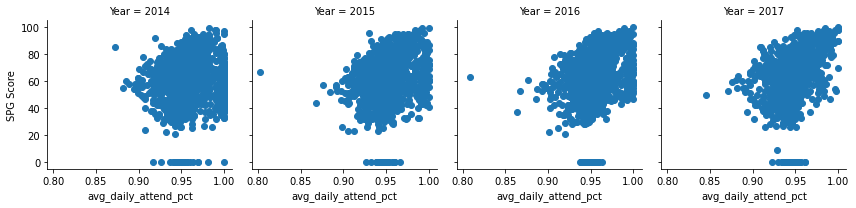

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

grid = sns.FacetGrid(schools, col="Year")
grid.map(plt.scatter, 'avg_daily_attend_pct', 'SPG Score')




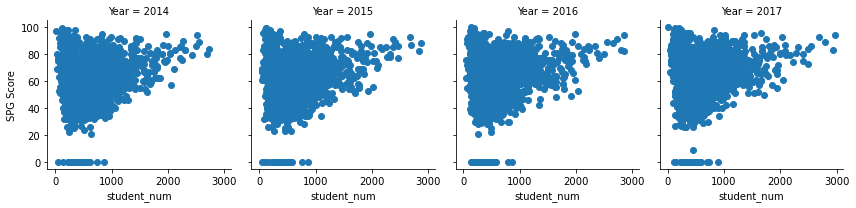

In [20]:

grid = sns.FacetGrid(schools, col='Year')
grid.map(plt.scatter, 'student_num', 'SPG Score')


While this isn't a good measure of class size (we have no way of measuring student/teacher ratio. Just raw number of students), it's interesting to observe that larger public schools generally receive higher grades than smaller ones. It could be the case that here the size of the school is a stand-in for the rurality of the school. In rural areas, schools will be smaller, and there will be fewer opportunities for students. What happens when we color by the majority-minority variable? Of particular interest are high schools.

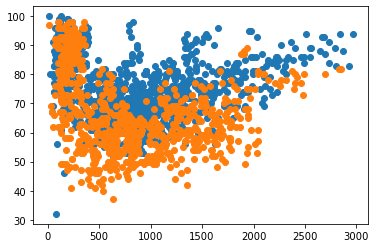

In [11]:

highschools = schools[schools['category_cd_modified'] == 'High School']

groups = highschools.groupby('Majority_Minority')

for name, group in groups:
    plt.plot(group["student_num"], group["SPG Score"], marker="o", linestyle="")


High schools exhibit a particularly interesting trend. There seems to be some benefit to being either an exceptionally small or large high school, but being medium sized seems to be detrimental to the overall school quality. Not sure why this would be.

Now let's turn our attention to teacher hiring. It would be reasonable to hypothesize that having teachers with more experience would result in better educational quality. Let's test it.

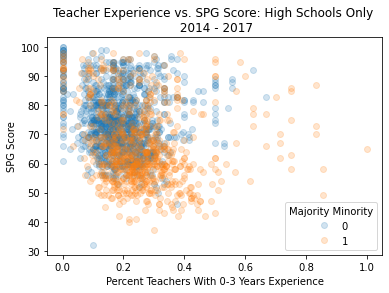

In [22]:

for name, group in groups:
    plt.plot(group['tchyrs_0thru3_pct'], group['SPG Score'], marker = "o", linestyle="", label=name, alpha=0.2)
    plt.xlabel("Percent Teachers With 0-3 Years Experience")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: High Schools Only \n 2014 - 2017")
    plt.legend(title="Majority Minority")



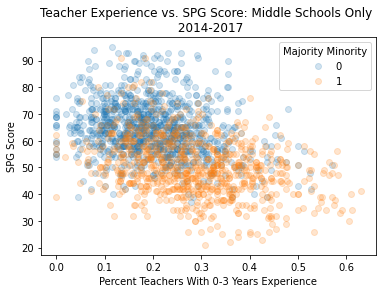

In [21]:
middleschools = schools[schools['category_cd_modified'] == 'Middle School']
groups_m = middleschools.groupby('Majority_Minority')

for name, group in groups_m:
    plt.plot(group['tchyrs_0thru3_pct'], group['SPG Score'], marker = "o", linestyle="", label=name, alpha=0.2)
    plt.xlabel("Percent Teachers With 0-3 Years Experience")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: Middle Schools Only \n 2014-2017")
    plt.legend(title="Majority Minority")

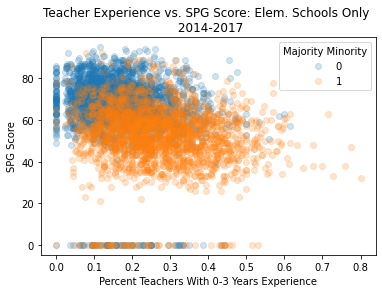

In [14]:


elemschools = schools[schools['category_cd_modified'] == 'Elementary School']
groups_e = elemschools.groupby('Majority_Minority')

for name, group in groups_e:
    plt.plot(group['tchyrs_0thru3_pct'], group['SPG Score'], marker = "o", linestyle="", label=name, alpha=0.2)
    plt.xlabel("Percent Teachers With 0-3 Years Experience")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: Elem. Schools Only \n 2014-2017")
    plt.legend(title="Majority Minority")


Does disciplinary policy effect school quality? Let's take a look at suspensions. 

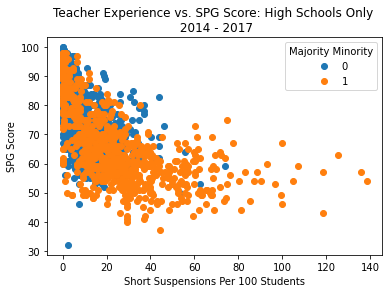

In [15]:
for name, group in groups:
    plt.plot(group['short_susp_per_c_num'], group['SPG Score'], marker = "o", linestyle="", label=name)
    plt.xlabel("Short Suspensions Per 100 Students")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: High Schools Only \n 2014 - 2017")
    plt.legend(title="Majority Minority")


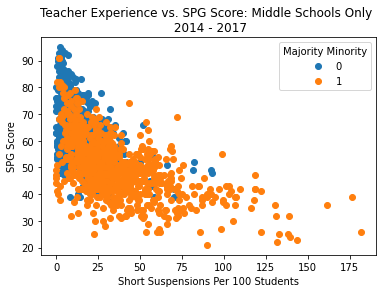

In [16]:
for name, group in groups_m:
    plt.plot(group['short_susp_per_c_num'], group['SPG Score'], marker = "o", linestyle="", label=name)
    plt.xlabel("Short Suspensions Per 100 Students")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: Middle Schools Only \n 2014 - 2017")
    plt.legend(title="Majority Minority")


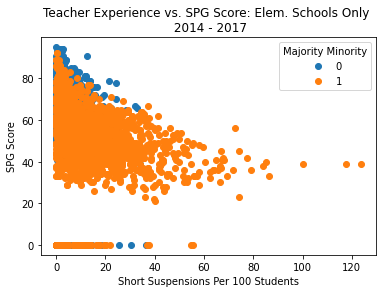

In [17]:
for name, group in groups_e:
    plt.plot(group['short_susp_per_c_num'], group['SPG Score'], marker = "o", linestyle="", label=name)
    plt.xlabel("Short Suspensions Per 100 Students")
    plt.ylabel("SPG Score")
    plt.title("Teacher Experience vs. SPG Score: Elem. Schools Only \n 2014 - 2017")
    plt.legend(title="Majority Minority")

In [18]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn import metrics

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing category_cd_modified
enc_df = pd.DataFrame(enc.fit_transform(schools[['category_cd_modified']]).toarray())

#Creating working dataframe for regression

X = schools[['Majority_Minority', 'avg_daily_attend_pct', 'student_num', 'tchyrs_0thru3_pct', 'short_susp_per_c_num']]

X = pd.concat([X.reset_index(drop=True), enc_df], axis=1)

y = schools['SPG Score']

#Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Train model on training set
regressor = LinearRegression()  
regressor.fit(X_train, y_train)




LinearRegression()

Code above adapted from the following articles: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f and 

https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd


In [19]:

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root Mean Squared Error: 11.002376519436416
